# FixRes: Fixing train-test resolution discrepancy

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/10/08<br>
**Last modified:** 2021/10/10<br>
**Description:** Mitigating resolution discrepancy between training and test sets.

## Introduction

It is a common practice to use the same input image resolution while training and testing
vision models. However, as investigated in
[Fixing the train-test resolution discrepancy](https://arxiv.org/abs/1906.06423)
(Touvron et al.), this practice leads to suboptimal performance. Data augmentation
is an indispensable part of the training process of deep neural networks. For vision models, we
typically use random resized crops during training and center crops during inference.
This introduces a discrepancy in the object sizes seen during training and inference.
As shown by Touvron et al., if we can fix this discrepancy, we can significantly
boost model performance.

In this example, we implement the **FixRes** techniques introduced by Touvron et al.
to fix this discrepancy.

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

2023-06-16 12:07:46.379994: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load the `tf_flowers` dataset

In [2]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)

num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Number of training examples: 3303
Number of validation examples: 367


2023-06-16 12:07:47.551017: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-06-16 12:07:47.551046: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: zlabshwa01
2023-06-16 12:07:47.551051: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: zlabshwa01
2023-06-16 12:07:47.551131: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 530.30.2
2023-06-16 12:07:47.551149: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.105.1
2023-06-16 12:07:47.551153: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.105.1 does not match DSO version 530.30.2 -- cannot find working devices in this configuration
2023-06-16 12:07:47.551358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tens

## Data preprocessing utilities

We create three datasets:

1. A dataset with a smaller resolution - 128x128.
2. Two datasets with a larger resolution - 224x224.

We will apply different augmentation transforms to the larger-resolution datasets.

The idea of FixRes is to first train a model on a smaller resolution dataset and then fine-tune
it on a larger resolution dataset. This simple yet effective recipe leads to non-trivial performance
improvements. Please refer to the [original paper](https://arxiv.org/abs/1906.06423) for
results.

In [3]:
# Reference: https://github.com/facebookresearch/FixRes/blob/main/transforms_v2.py.

batch_size = 128
auto = tf.data.AUTOTUNE
smaller_size = 128
bigger_size = 224

size_for_resizing = int((bigger_size / smaller_size) * bigger_size)
central_crop_layer = layers.CenterCrop(bigger_size, bigger_size)


def preprocess_initial(train, image_size):
    """Initial preprocessing function for training on smaller resolution.

    For training, do random_horizontal_flip -> random_crop.
    For validation, just resize.
    No color-jittering has been used.
    """

    def _pp(image, label, train):
        if train:
            channels = image.shape[-1]
            begin, size, _ = tf.image.sample_distorted_bounding_box(
                tf.shape(image),
                tf.zeros([0, 0, 4], tf.float32),
                area_range=(0.05, 1.0),
                min_object_covered=0,
                use_image_if_no_bounding_boxes=True,
            )
            image = tf.slice(image, begin, size)

            image.set_shape([None, None, channels])
            image = tf.image.resize(image, [image_size, image_size])
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, [image_size, image_size])

        return image, label

    return _pp


def preprocess_finetune(image, label, train):
    """Preprocessing function for fine-tuning on a higher resolution.

    For training, resize to a bigger resolution to maintain the ratio ->
        random_horizontal_flip -> center_crop.
    For validation, do the same without any horizontal flipping.
    No color-jittering has been used.
    """
    image = tf.image.resize(image, [size_for_resizing, size_for_resizing])
    if train:
        image = tf.image.random_flip_left_right(image)
    image = central_crop_layer(image[None, ...])[0]

    return image, label


def make_dataset(
    dataset: tf.data.Dataset,
    train: bool,
    image_size: int = smaller_size,
    fixres: bool = True,
    num_parallel_calls=auto,
):
    if image_size not in [smaller_size, bigger_size]:
        raise ValueError(f"{image_size} resolution is not supported.")

    # Determine which preprocessing function we are using.
    if image_size == smaller_size:
        preprocess_func = preprocess_initial(train, image_size)
    elif not fixres and image_size == bigger_size:
        preprocess_func = preprocess_initial(train, image_size)
    else:
        preprocess_func = preprocess_finetune

    if train:
        dataset = dataset.shuffle(batch_size * 10)

    return (
        dataset.map(
            lambda x, y: preprocess_func(x, y, train),
            num_parallel_calls=num_parallel_calls,
        )
        .batch(batch_size)
        .prefetch(num_parallel_calls)
    )


Notice how the augmentation transforms vary for the kind of dataset we are preparing.

## Prepare datasets

In [4]:
initial_train_dataset = make_dataset(train_dataset, train=True, image_size=smaller_size)
initial_val_dataset = make_dataset(val_dataset, train=False, image_size=smaller_size)

finetune_train_dataset = make_dataset(train_dataset, train=True, image_size=bigger_size)
finetune_val_dataset = make_dataset(val_dataset, train=False, image_size=bigger_size)

vanilla_train_dataset = make_dataset(
    train_dataset, train=True, image_size=bigger_size, fixres=False
)
vanilla_val_dataset = make_dataset(
    val_dataset, train=False, image_size=bigger_size, fixres=False
)

## Visualize the datasets

2023-06-16 12:07:48.139073: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


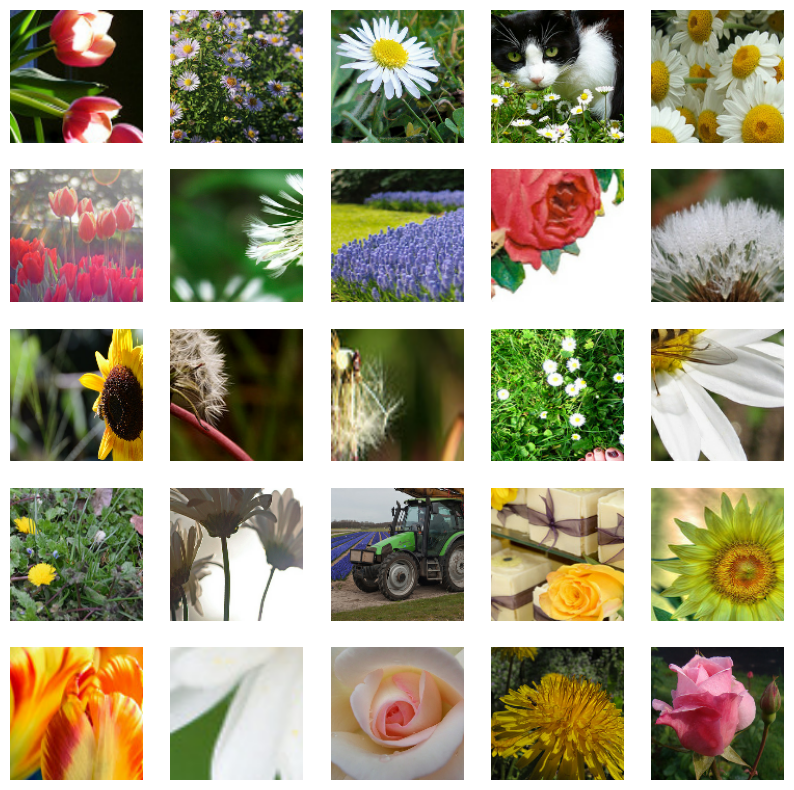

Batch shape: (128, 128, 128, 3).


2023-06-16 12:07:48.787872: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


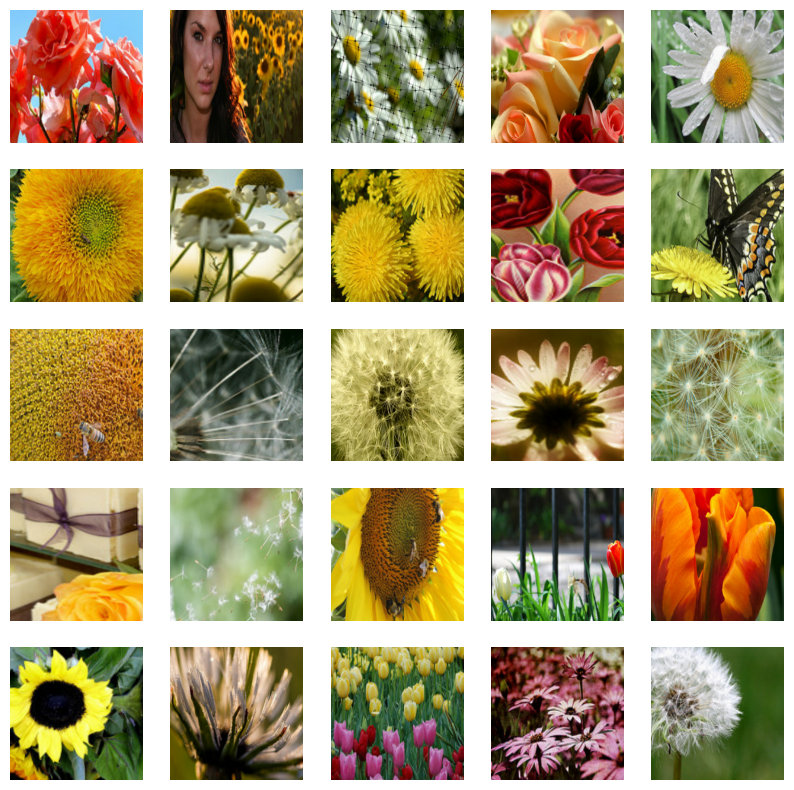

Batch shape: (128, 224, 224, 3).


2023-06-16 12:07:49.433914: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


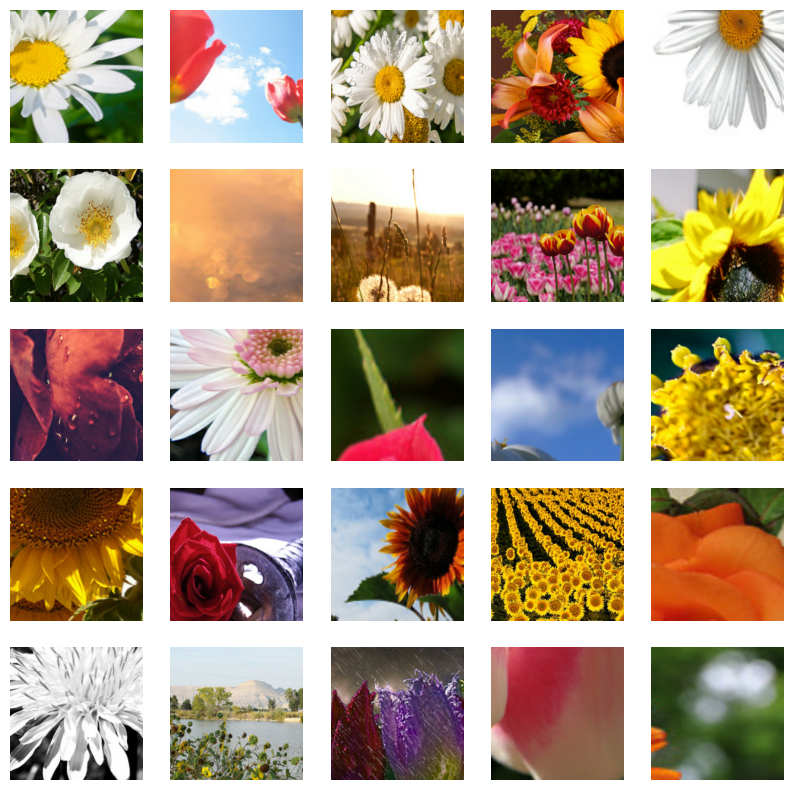

Batch shape: (128, 224, 224, 3).


In [5]:

def visualize_dataset(batch_images):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(batch_images[n].numpy().astype("int"))
        plt.axis("off")
    plt.show()

    print(f"Batch shape: {batch_images.shape}.")


# Smaller resolution.
initial_sample_images, _ = next(iter(initial_train_dataset))
visualize_dataset(initial_sample_images)

# Bigger resolution, only for fine-tuning.
finetune_sample_images, _ = next(iter(finetune_train_dataset))
visualize_dataset(finetune_sample_images)

# Bigger resolution, with the same augmentation transforms as
# the smaller resolution dataset.
vanilla_sample_images, _ = next(iter(vanilla_train_dataset))
visualize_dataset(vanilla_sample_images)

## Model training utilities

We train multiple variants of ResNet50V2
([He et al.](https://arxiv.org/abs/1603.05027)):

1. On the smaller resolution dataset (128x128). It will be trained from scratch.
2. Then fine-tune the model from 1 on the larger resolution (224x224) dataset.
3. Train another ResNet50V2 from scratch on the larger resolution dataset.

As a reminder, the larger resolution datasets differ in terms of their augmentation
transforms.

In [6]:

def get_training_model(num_classes=5):
    inputs = layers.Input((None, None, 3))
    resnet_base = keras.applications.ResNet50V2(
        include_top=False, weights=None, pooling="avg"
    )
    resnet_base.trainable = True

    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = resnet_base(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


def train_and_evaluate(
    model, train_ds, val_ds, epochs, learning_rate=1e-3, use_early_stopping=False
):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    if use_early_stopping:
        es_callback = keras.callbacks.EarlyStopping(patience=5)
        callbacks = [es_callback]
    else:
        callbacks = None

    model.fit(
        train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks,
    )

    _, accuracy = model.evaluate(val_ds)
    print(f"Top-1 accuracy on the validation set: {accuracy*100:.2f}%.")
    return model


## Experiment 1: Train on 128x128 and then fine-tune on 224x224

In [7]:
epochs = 30

smaller_res_model = get_training_model()
smaller_res_model = train_and_evaluate(
    smaller_res_model, initial_train_dataset, initial_val_dataset, epochs
)

Epoch 1/30
26/26 [==============================] - 41s 2s/step - loss: 1.5937 - accuracy: 0.4541 - val_loss: 144.2891 - val_accuracy: 0.2071
Epoch 2/30
26/26 [==============================] - 39s 1s/step - loss: 1.1491 - accuracy: 0.5471 - val_loss: 10.1320 - val_accuracy: 0.2698
Epoch 3/30
26/26 [==============================] - 39s 1s/step - loss: 1.0857 - accuracy: 0.5798 - val_loss: 1.9038 - val_accuracy: 0.2643
Epoch 4/30
26/26 [==============================] - 39s 1s/step - loss: 1.0495 - accuracy: 0.6061 - val_loss: 2.0021 - val_accuracy: 0.2561
Epoch 5/30
26/26 [==============================] - 39s 1s/step - loss: 1.0281 - accuracy: 0.6091 - val_loss: 1.8282 - val_accuracy: 0.2970
Epoch 6/30
26/26 [==============================] - 39s 1s/step - loss: 0.9922 - accuracy: 0.6228 - val_loss: 1.5178 - val_accuracy: 0.4142
Epoch 7/30
26/26 [==============================] - 39s 1s/step - loss: 0.9725 - accuracy: 0.6197 - val_loss: 1.2799 - val_accuracy: 0.5259
Epoch 8/30
26/26 

### Freeze all the layers except for the final Batch Normalization layer

For fine-tuning, we train only two layers:

* The final Batch Normalization ([Ioffe et al.](https://arxiv.org/abs/1502.03167)) layer.
* The classification layer.

We are unfreezing the final Batch Normalization layer to compensate for the change in
activation statistics before the global average pooling layer. As shown in
[the paper](https://arxiv.org/abs/1906.06423), unfreezing the final Batch
Normalization layer is enough.

For a comprehensive guide on fine-tuning models in Keras, refer to
[this tutorial](https://keras.io/guides/transfer_learning/).

In [8]:
for layer in smaller_res_model.layers[2].layers:
    layer.trainable = False

smaller_res_model.layers[2].get_layer("post_bn").trainable = True

epochs = 10

# Use a lower learning rate during fine-tuning.
bigger_res_model = train_and_evaluate(
    smaller_res_model,
    finetune_train_dataset,
    finetune_val_dataset,
    epochs,
    learning_rate=1e-4,
)

Epoch 1/10
26/26 [==============================] - 46s 2s/step - loss: 0.8797 - accuracy: 0.7481 - val_loss: 0.8134 - val_accuracy: 0.7221
Epoch 2/10
26/26 [==============================] - 45s 2s/step - loss: 0.8587 - accuracy: 0.7469 - val_loss: 0.8025 - val_accuracy: 0.7439
Epoch 3/10
26/26 [==============================] - 45s 2s/step - loss: 0.8429 - accuracy: 0.7499 - val_loss: 0.7964 - val_accuracy: 0.7439
Epoch 4/10
26/26 [==============================] - 45s 2s/step - loss: 0.8332 - accuracy: 0.7454 - val_loss: 0.7964 - val_accuracy: 0.7357
Epoch 5/10
26/26 [==============================] - 45s 2s/step - loss: 0.8244 - accuracy: 0.7511 - val_loss: 0.7952 - val_accuracy: 0.7411
Epoch 6/10
26/26 [==============================] - 45s 2s/step - loss: 0.8127 - accuracy: 0.7526 - val_loss: 0.7895 - val_accuracy: 0.7520
Epoch 7/10
26/26 [==============================] - 45s 2s/step - loss: 0.8068 - accuracy: 0.7533 - val_loss: 0.7865 - val_accuracy: 0.7493
Epoch 8/10
26/26 [==

## Experiment 2: Train a model on 224x224 resolution from scratch

Now, we train another model from scratch on the larger resolution dataset. Recall that
the augmentation transforms used in this dataset are different from before.

In [ ]:
epochs = 30

vanilla_bigger_res_model = get_training_model()
vanilla_bigger_res_model = train_and_evaluate(
    vanilla_bigger_res_model, vanilla_train_dataset, vanilla_val_dataset, epochs
)

Epoch 1/30
26/26 [==============================] - 114s 4s/step - loss: 1.5397 - accuracy: 0.4429 - val_loss: 621.0751 - val_accuracy: 0.2071
Epoch 2/30
23/26 [=========================>....] - ETA: 12s - loss: 1.1830 - accuracy: 0.5363

As we can notice from the above cells, FixRes leads to a better performance. Another
advantage of FixRes is the improved total training time and reduction in GPU memory usage.
FixRes is model-agnostic, you can use it on any image classification model
to potentially boost performance.

You can find more results
[here](https://tensorboard.dev/experiment/BQOg28w0TlmvuJYeqsVntw)
that were gathered by running the same code with different random seeds.